In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import joblib

**Define input data and plot them**

In [2]:
# Define lookback and prediction horizon
lookback = 10
horizon = 1

In [3]:
#define input data
data=pd.DataFrame({'y': np.arange(5,255,5)})

data.tail(5)


,y
45,230
46,235
47,240
48,245
49,250


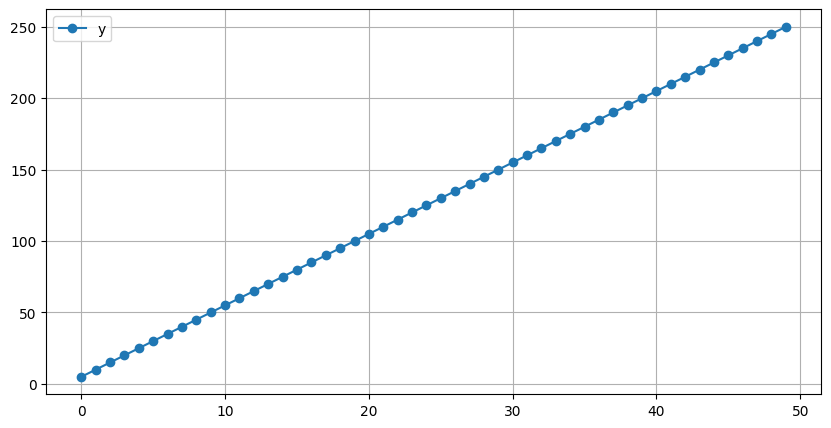

In [4]:
data.plot(figsize=(10,5), marker='o')
plt.grid()
plt.show()

In [5]:
""" #convert into an array
data=np.array(data)
data[0:5] """

' #convert into an array\ndata=np.array(data)\ndata[0:5] '

**Scale and parce the data**

In [6]:
#scale data
scaler = MinMaxScaler(feature_range= (0,1))
data = scaler.fit_transform(data)

In [7]:
# Function to create input sequences and corresponding output for training
def create_sequences(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)

# Create input sequences and corresponding output
X, y = create_sequences(data, lookback, horizon)


In [8]:
# Split the data into training and testing sets
train_size = int(len(X)-lookback)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

**Build the NN and compute**

In [9]:
#clear previous TensorFlow session
K.clear_session()

#Build the LSTM model
model = Sequential()
model.add(LSTM(40, input_shape=(lookback, 1)))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

#Train the model
history=model.fit(X_train, y_train, epochs=1000, batch_size=10, validation_data=(X_test, y_test), verbose=0)

#Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")





1/1 [==============================] - 1s 524ms/step - loss: 1.0638e-04
Test Loss: 0.00010637564264470711


In [10]:
#define ploting function for loss function

def plot_training(history_dict, y_axis=[0, 1000]):

    plt.plot(history_dict.history['loss'], label='Loss-Training',  c="blue")
    plt.plot(history_dict.history['val_loss'], label='Loss-Test', c="red")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.ylim(y_axis) #limit of the Y-axis

    plt.legend()
    plt.grid(True)

    plt.show()

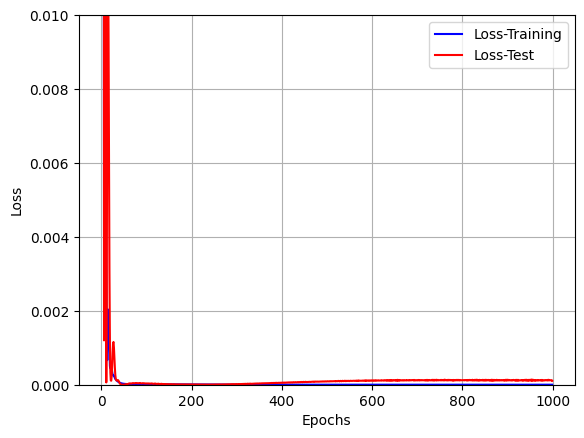

In [11]:
#plot without dropout
plot_training(history,y_axis=[0, 0.01])

**Predict**

In [12]:
#Predict the next time steps
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 531ms/step


In [13]:
#last prediction=last item of array
y_pred=y_pred.reshape(-1,1)

#scale back
y_pred_trans = scaler.inverse_transform(y_pred)

y_pred_trans

array([[204.43762],
       [209.17717],
       [213.87923],
       [218.54233],
       [223.1651 ],
       [227.7463 ],
       [232.28479],
       [236.77937],
       [241.2292 ],
       [245.63332]], dtype=float32)

In [14]:
#check if 2D shape
y_pred_trans.shape

(10, 1)

In [15]:
y_test=y_test.reshape(-1,1)

#scale back
y_test_trans = scaler.inverse_transform(y_test)
y_test_trans

array([[205.],
       [210.],
       [215.],
       [220.],
       [225.],
       [230.],
       [235.],
       [240.],
       [245.],
       [250.]])

In [16]:
#check if 2D shape
y_test_trans.shape

(10, 1)

**Plot results**

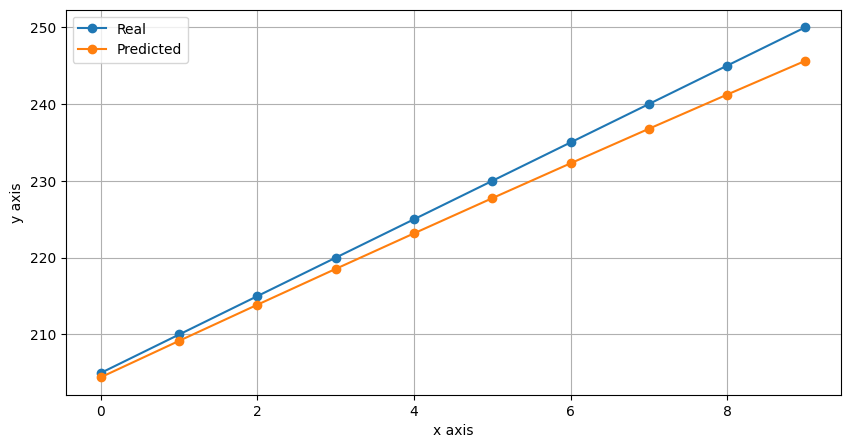

In [17]:
#Plot results for test part

plt.figure(figsize=(10,5))

plt.plot(y_test_trans, label = 'Real', marker='o')
plt.plot(y_pred_trans, label = 'Predicted', marker='o')

plt.grid()
plt.ylabel('y axis')
plt.xlabel('x axis')

plt.legend()
plt.show()

**Evaluate data - RMSE**

In [18]:
#calculate root mean squared error
test_score = np.sqrt(mse(y_test_trans, y_pred_trans))

#print results
print(f'RMSE: {round(test_score,2)}')


RMSE: 2.53


**Predict beyond the test set**

In [19]:
#we will use parced data X and y = they represent the whole dataset = the end of dataset!!!

In [20]:
#data (train+test)
X[-1]

array([[0.79591837],
       [0.81632653],
       [0.83673469],
       [0.85714286],
       [0.87755102],
       [0.89795918],
       [0.91836735],
       [0.93877551],
       [0.95918367],
       [0.97959184]])

In [21]:
#scale them
scaler.inverse_transform(X[-1])

array([[200.],
       [205.],
       [210.],
       [215.],
       [220.],
       [225.],
       [230.],
       [235.],
       [240.],
       [245.]])

In [22]:
#Fit the model
history=model.fit(X,y, epochs=1000, batch_size=10, verbose=0)
final_loss = history.history['loss'][-1]
final_loss

5.946804435552622e-07

In [23]:
#Save the fitted model
joblib.dump(model, 'lstm-model.pkl')

['lstm-model.pkl']

In [24]:
#create an empty list for each of our 12 predictions
#create the batch that our model will predict off of
#save the prediction to our list
#add the prediction to the end of the batch to be used in the next prediction

pred_list = []  

#takes the last data from the dataset
batch = data[-lookback:].reshape((1, lookback, horizon))
batch

for i in range(lookback):
    pred_list.append(model.predict(batch)[0])   
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)


1/1 [==============================] - 0s 39ms/step


In [25]:
batch.shape

(1, 10, 1)

In [26]:
#print the results
results=scaler.inverse_transform(pred_list)

results_df=pd.DataFrame(results, columns=['Predicted'])
print(results_df)

    Predicted
0  254.586086
1  259.404012
2  264.183677
3  268.917401
4  273.602643
5  278.236598
6  282.816259
7  287.338063
8  291.798737
9  296.194749


**Plot future predictions**

In [27]:
# Set the new index starting from 20 to the end

new_index = np.arange(len(data), len(data) + len(results_df))

results_df = results_df.set_index(pd.Index(new_index))
results_df

,Predicted
50,254.586086
51,259.404012
52,264.183677
53,268.917401
54,273.602643
55,278.236598
56,282.816259
57,287.338063
58,291.798737
59,296.194749


In [28]:
data_df=scaler.inverse_transform(data)
data_df=pd.DataFrame(data_df,columns=['Real (train+test)'])

df_final = pd.concat([data_df,results_df], axis=1)

In [29]:
df_final.head(3)

,Real (train+test),Predicted
0,5.0,NaN
1,10.0,NaN
2,15.0,NaN


In [30]:
df_final.tail(3)

,Real (train+test),Predicted
57,NaN,287.338063
58,NaN,291.798737
59,NaN,296.194749


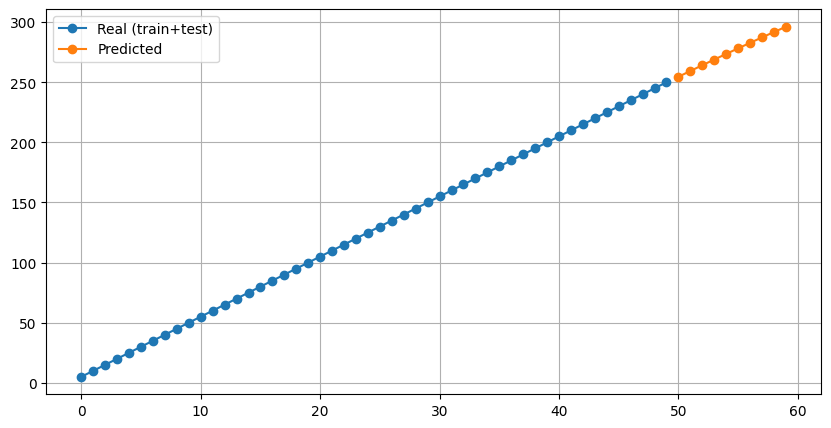

In [31]:
#Plot a chart
df_final[['Real (train+test)', 'Predicted']].plot(figsize=(10, 5), marker='o')
plt.grid(True)
plt.show()